## Import

In [45]:
import random
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings(action='ignore') 

ModuleNotFoundError: No module named 'torch'

## Fixed Random-Seed

In [25]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [41]:
train_df = pd.read_csv('./train.csv')
trade_df=pd.read_csv('./international_trade.csv')
test_df = pd.read_csv('./test.csv')

In [3]:
count_zero_supply = (train_df['supply(kg)'] == 0).sum()
print(count_zero_supply)

35452


In [20]:
unique_items = trade_df['품목명'].unique()

# 고유한 품목명을 출력합니다.
for item in unique_items:
    print(item)
desired_items = ['꽃양배추와 브로콜리(broccoli)', '방울다다기 양배추', '양배추', '당근', '감귤', '순무']

# '품목명' 칼럼에서 원하는 품목만을 가진 행을 선택합니다.
filtered_df = trade_df[trade_df['품목명'].isin(desired_items)]

# 새로운 데이터프레임을 출력하거나 필요한 작업을 수행합니다.
print(filtered_df)

# 데이터프레임을 CSV 파일로 저장
filtered_df.to_csv("filtered_data.csv", index=False)

토마토(신선한 것이나 냉장한 것으로 한정한다)
양파
쪽파
꽃양배추와 브로콜리(broccoli)
방울다다기 양배추
양배추
결구(結球) 상추
위트루프 치커리(Witloof chicory)[시코리엄 인티부스 변종 포리오섬(Cichorium intybus var. foliosum)]
당근
오이류(신선한 것이나 냉장한 것으로 한정한다)
콩[비그나(Vigna)속ㆍ파세러스(Phaseolus)속)]
대추야자
무화과
파인애플
망고(mango)
망고스틴(mangosteen)
오렌지
감귤
그레이프프루트(grapefruit)와 포멜로(pomelo)
레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]
수박
포포(papaw)[파파야(papaya)]
사과
배
자두
완두[피섬 새티범(Pisum sativum)]
구아바(guava)
살구
신 체리[프루너스 체라서스(Prunus cerasus)]
복숭아[넥터린(nectarine)을 포함한다]
순무
방울토마토
샬롯(shallot)
참외
           기간                   품목명   수출 중량  수출 금액    수입 중량  수입 금액  무역수지
3     2019-01  꽃양배추와 브로콜리(broccoli)     160      1   638913    563  -562
4     2019-01             방울다다기 양배추       0      0     7580     38   -38
5     2019-01                   양배추  184650     94   395802     90     4
8     2019-01                    당근   23150     22  7466150   2955 -2934
17    2019-01                    감귤   58368    172        0      0   172
...       ...                   ...     ...    ...      .

## Data Pre-Processing

In [42]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

In [43]:
train_data=train_df
test_data=test_df
trade_data=trade_df

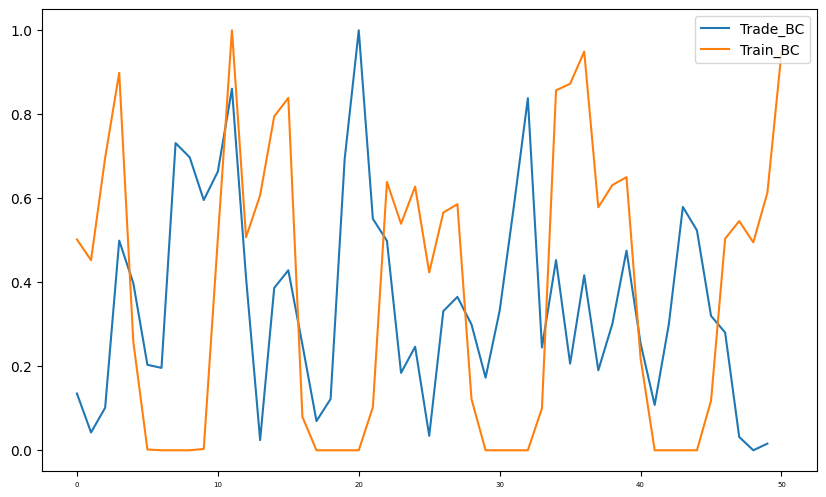

In [53]:
# international_trade.csv의 수입 금액과 train data의 price(원/kg) 의 비교
compare_item = "브로콜리"
compare_item_en = "BC"

item_trade_data = trade_data[trade_data['품목명'].str.contains(compare_item)].groupby(['기간']).sum()
item_trade_data['수입 금액'] = (item_trade_data['수입 금액'].values - item_trade_data['수입 금액'].values.min()) / (item_trade_data['수입 금액'].values.max() - item_trade_data['수입 금액'].values.min())

item_train_data =shift = 4

plt.figure(figsize=(10, 6))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(item_trade_data.index)) + shift, item_trade_data['수입 중량'].to_numpy(), label=f'Trade_{compare_item_en}')
plt.plot(np.arange(len(item_train_data.index)), item_train_data['price(원/kg)'].to_numpy(), label=f'Train_{compare_item_en}')
plt.legend(loc='upper right')
plt.show()train_data[train_data['item'] == compare_item_en].groupby(['year', 'month'])[['supply(kg)', 'price(원/kg)']].mean().reset_index()
item_train_data['price(원/kg)'] = (item_train_data['price(원/kg)'] - item_train_data['price(원/kg)'].min()) / (item_train_data['price(원/kg)'].max() - item_train_data['price(원/kg)'].min())

plt.figure(figsize=(10, 6))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(item_trade_data.index)), item_trade_data['수입 금액'].to_numpy(), label=f'Trade_{compare_item_en}')
plt.plot(np.arange(len(item_train_data.index)), item_train_data['price(원/kg)'].to_numpy(), label=f'Train_{compare_item_en}')
plt.legend(loc='upper right')
plt.show()

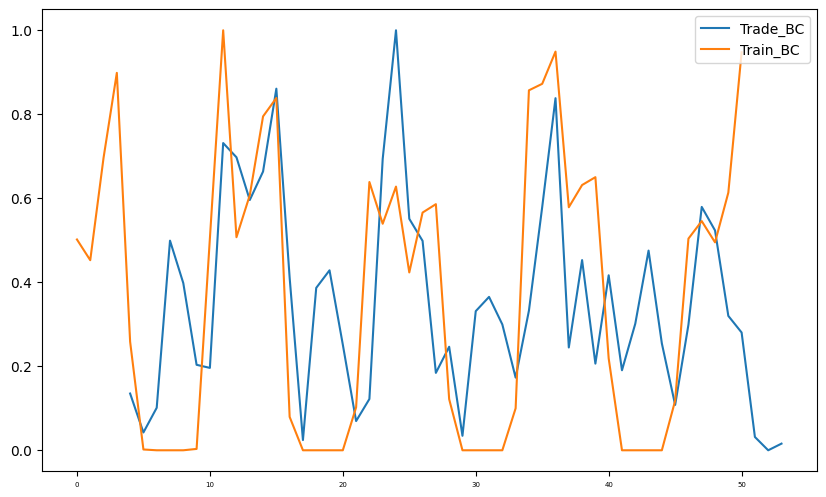

In [54]:
shift = 4

plt.figure(figsize=(10, 6))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(item_trade_data.index)) + shift, item_trade_data['수입 금액'].to_numpy(), label=f'Trade_{compare_item_en}')
plt.plot(np.arange(len(item_train_data.index)), item_train_data['price(원/kg)'].to_numpy(), label=f'Train_{compare_item_en}')
plt.legend(loc='upper right')
plt.show()

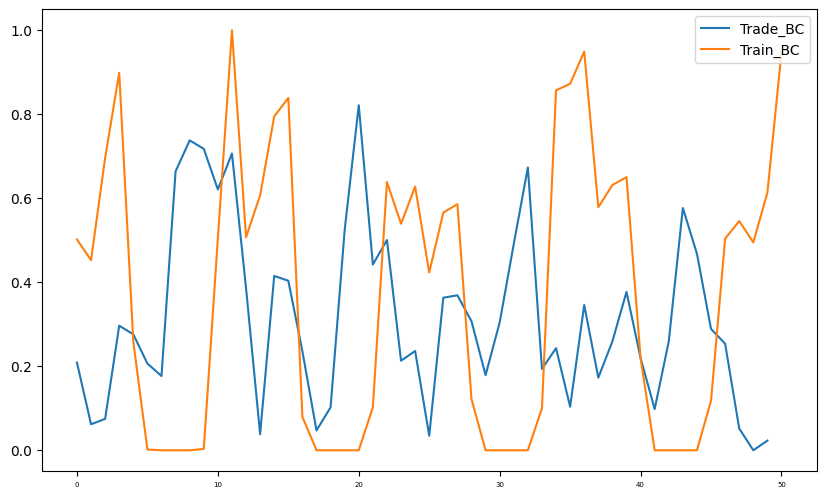

In [51]:
# international_trade.csv의 수입 금액과 train data의 price(원/kg) 의 비교
compare_item = "브로콜리"
compare_item_en = "BC"

item_trade_data = trade_data[trade_data['품목명'].str.contains(compare_item)].groupby(['기간']).sum()
item_trade_data['수입 중량'] = (item_trade_data['수입 중량'].values - item_trade_data['수입 중량'].values.min()) / (item_trade_data['수입 중량'].values.max() - item_trade_data['수입 금액'].values.min())

item_train_data = train_data[train_data['item'] == compare_item_en].groupby(['year', 'month'])[['supply(kg)', 'price(원/kg)']].mean().reset_index()
item_train_data['price(원/kg)'] = (item_train_data['price(원/kg)'] - item_train_data['price(원/kg)'].min()) / (item_train_data['price(원/kg)'].max() - item_train_data['price(원/kg)'].min())

plt.figure(figsize=(10, 6))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(item_trade_data.index)), item_trade_data['수입 중량'].to_numpy(), label=f'Trade_{compare_item_en}')
plt.plot(np.arange(len(item_train_data.index)), item_train_data['price(원/kg)'].to_numpy(), label=f'Train_{compare_item_en}')
plt.legend(loc='upper right')
plt.show()

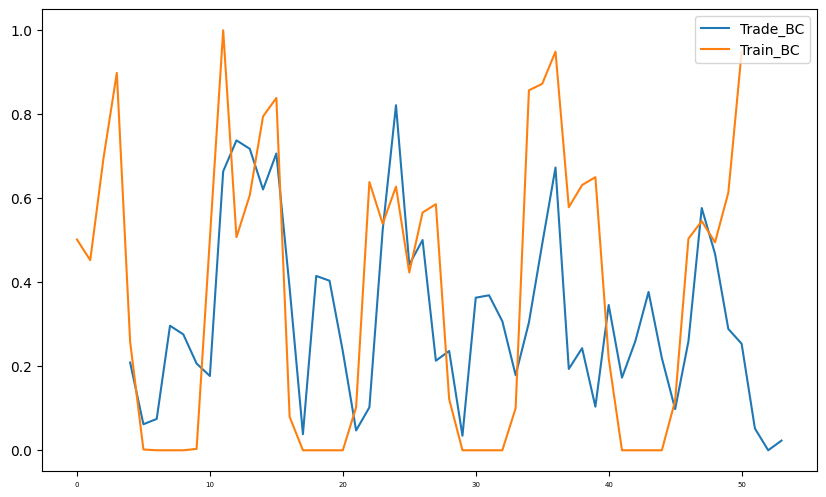

In [52]:
shift = 4

plt.figure(figsize=(10, 6))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(item_trade_data.index)) + shift, item_trade_data['수입 중량'].to_numpy(), label=f'Trade_{compare_item_en}')
plt.plot(np.arange(len(item_train_data.index)), item_train_data['price(원/kg)'].to_numpy(), label=f'Train_{compare_item_en}')
plt.legend(loc='upper right')
plt.show()

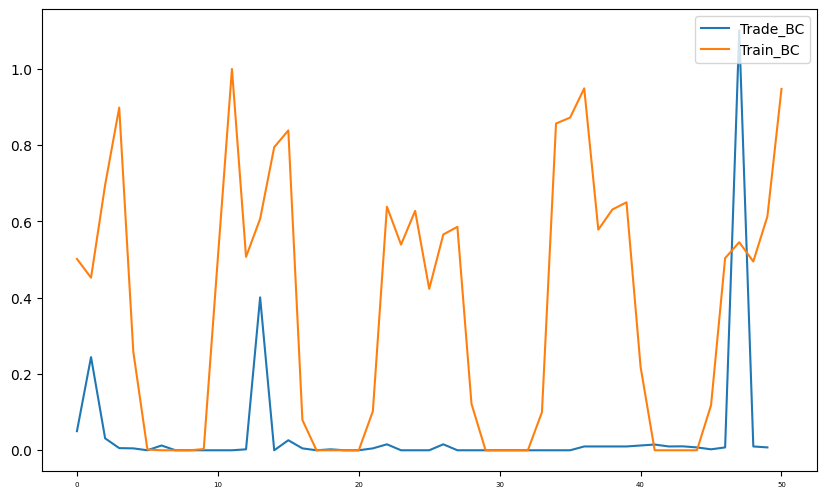

In [55]:
# international_trade.csv의 수입 금액과 train data의 price(원/kg) 의 비교
compare_item = "브로콜리"
compare_item_en = "BC"

item_trade_data = trade_data[trade_data['품목명'].str.contains(compare_item)].groupby(['기간']).sum()
item_trade_data['수출 중량'] = (item_trade_data['수출 중량'].values - item_trade_data['수출 중량'].values.min()) / (item_trade_data['수출 중량'].values.max() - item_trade_data['수입 금액'].values.min())

item_train_data = train_data[train_data['item'] == compare_item_en].groupby(['year', 'month'])[['supply(kg)', 'price(원/kg)']].mean().reset_index()
item_train_data['price(원/kg)'] = (item_train_data['price(원/kg)'] - item_train_data['price(원/kg)'].min()) / (item_train_data['price(원/kg)'].max() - item_train_data['price(원/kg)'].min())

plt.figure(figsize=(10, 6))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(item_trade_data.index)), item_trade_data['수출 중량'].to_numpy(), label=f'Trade_{compare_item_en}')
plt.plot(np.arange(len(item_train_data.index)), item_train_data['price(원/kg)'].to_numpy(), label=f'Train_{compare_item_en}')
plt.legend(loc='upper right')
plt.show()

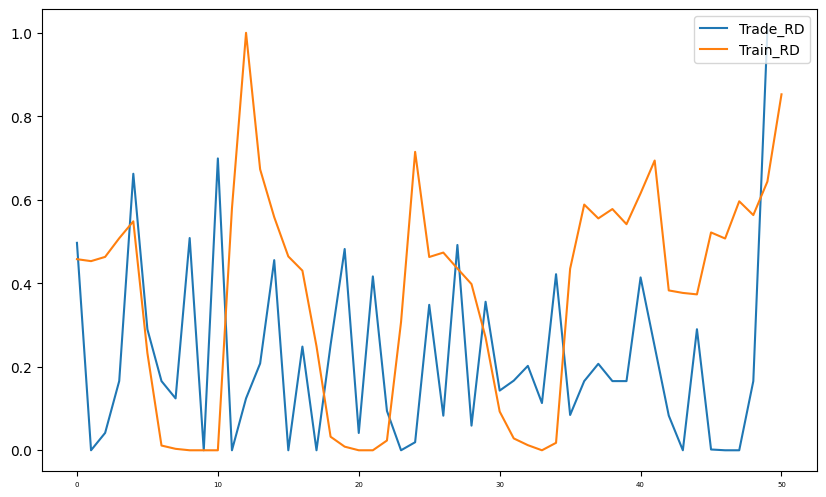

In [56]:
# international_trade.csv의 수입 금액과 train data의 price(원/kg) 의 비교
compare_item = "무"
compare_item_en = "RD"

item_trade_data = trade_data[trade_data['품목명'].str.contains(compare_item)].groupby(['기간']).sum()
item_trade_data['수출 중량'] = (item_trade_data['수출 중량'].values - item_trade_data['수출 중량'].values.min()) / (item_trade_data['수출 중량'].values.max() - item_trade_data['수입 금액'].values.min())

item_train_data = train_data[train_data['item'] == compare_item_en].groupby(['year', 'month'])[['supply(kg)', 'price(원/kg)']].mean().reset_index()
item_train_data['price(원/kg)'] = (item_train_data['price(원/kg)'] - item_train_data['price(원/kg)'].min()) / (item_train_data['price(원/kg)'].max() - item_train_data['price(원/kg)'].min())

plt.figure(figsize=(10, 6))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(item_trade_data.index)), item_trade_data['수출 중량'].to_numpy(), label=f'Trade_{compare_item_en}')
plt.plot(np.arange(len(item_train_data.index)), item_train_data['price(원/kg)'].to_numpy(), label=f'Train_{compare_item_en}')
plt.legend(loc='upper right')
plt.show()

In [27]:
#학습에 사용하지 않을 변수들을 제거합니다
train_x = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)','price(원/kg)'])
train_y = train_df['price(원/kg)']

test_x = test_df.drop(columns=['ID', 'timestamp'])

In [28]:
#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train_x[i]=le.fit_transform(train_x[i])
    test_x[i]=le.transform(test_x[i]) #test 데이터에 대해서 fit하는 것은 data leakage에 해당합니다

print('Done.')

Done.


In [29]:
test_x

,item,corporation,location,year,month,day
0,4,0,0,2023,3,4
1,4,0,0,2023,3,5
2,4,0,0,2023,3,6
3,4,0,0,2023,3,7
4,4,0,0,2023,3,8
...,...,...,...,...,...,...
1087,3,5,0,2023,3,27
1088,3,5,0,2023,3,28
1089,3,5,0,2023,3,29
1090,3,5,0,2023,3,30


## Regression Model Fit

In [30]:
# XGBoost 모델 초기화
model = xgb.XGBRegressor()

# 모델을 훈련 데이터에 맞추기
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Inference

In [31]:
preds = model.predict(test_x)

## Submission

In [33]:
submission = pd.read_csv('./sample_submission.csv')
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [34]:
submission['answer'] = preds
submission

,ID,answer
0,TG_A_J_20230304,3327.997803
1,TG_A_J_20230305,2981.728516
2,TG_A_J_20230306,2168.133301
3,TG_A_J_20230307,3015.339600
4,TG_A_J_20230308,3012.901611
...,...,...
1087,RD_F_J_20230327,-282.096405
1088,RD_F_J_20230328,499.539368
1089,RD_F_J_20230329,-135.349609
1090,RD_F_J_20230330,662.404846


In [35]:
submission.to_csv('./baseline_submission.csv', index=False)